# Plots for RRI Experiments near Ottawa 18-22 April 2016
May 3rd 2017
David Fairbairn

This document is an implementation in workbook format of many plotting functions which I've already written. Some logical separation of files was necessary for other reasons ipython workbooks would be a more appropriate format for doing plotting and tweaking parameters.

In [1]:
# Built-in Python dependencies
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from datetime import datetime as dt
# Some DaVitPy dependencies
from davitpy.utils import plotUtils
from davitpy.models import aacgm
from davitpy.models import igrf
# Some of my own analytical utilities
from data_utils import *
from script_utils import *
from analysis_tools import *
from ottawa_plots import *

## Plotting An ePOP Pass
The first and most common or simple plot: ground tracks of ePOP passes.

/usr/lib64/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/lib64/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib64/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


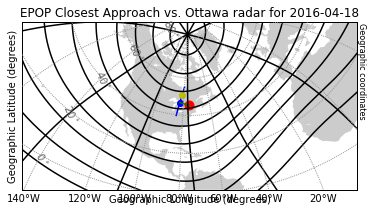

In [3]:
def plot_ottawa_ephem(date_string):
    """
    Put the plotting procedure for looking at satellite ephemeris vs. Ottawa
    transmitter into a function.

    Note that the transmitter is a Barker & Williamson Model 110.

    **PARAMS**
    geog_longs
    geog_lats
    alts
    ephemtimes
    date_string (String): String in the format of "20160418"

    *** RETURNS ***
    - (Just plots)

    """
    # TODO: fixup this documentation
    if isinstance(date_string, type(None)): date_string="20160418"
       
    fname,index_reversal = get_ottawa_data(date_string)
    geog_longs,geog_lats,alts,ephemtimes = get_rri_ephemeris(fname)

    # Location of Ottawa: I looked it up and hard-coded it at the top
    times = ephems_to_datetime(ephemtimes)

    indx_shortest, dists = get_closest_ottawa_approach(geog_longs, geog_lats, alts)
    appr_time = times[indx_shortest]
    
    # The numeric data type that I was retrieving from geog_longs, when _NOT_ stored
    # in an array, was being rejected by the mapObj() function below. So I convert 
    # these numbers to floats explicitly here.
    shortest_ephem_long = float(geog_longs[indx_shortest])
    shortest_ephem_lat = float(geog_lats[indx_shortest])
    inversion_ephem_long = float(geog_longs[index_reversal])
    inversion_ephem_lat = float(geog_lats[index_reversal])
    
    # A different font for the legend etc. might be nice
    #fig = plt.figure()
    font = {'fontname':'Computer Modern'}
    m = plotUtils.mapObj(lat_0=45.0, lon_0=-75.0, width=111e3*180, height=111e3*90, coords='geo',datetime=times[0])
    
    # FIRST: Plot the location of Ottawa
    x,y = m(OTTAWA_TX_LON,OTTAWA_TX_LAT,coords='geo')
    m.plot(x,y,'r-o',markersize=9,label="Ottawa")
    
    # SECOND: Plot the satellite ground-track.
    x,y = m(geog_longs, geog_lats, coords='geo')
    m.plot(x,y,'b',label="EPOP ground track")
    
    # THIRD: Plot a circle emphasizing the point of closest approach
    x,y = m(shortest_ephem_long,shortest_ephem_lat, coords='geo')
    m.plot(x,y,'bo',label=("Closest Approach at " + str(appr_time)))
    
    # FOURTH: Plot the line from Ottawa to the nearest approach of the satellite.
    x,y = m([shortest_ephem_long, OTTAWA_TX_LON], [shortest_ephem_lat, OTTAWA_TX_LAT], coords='geo')
    m.plot(x,y,'g')
    
    # FIFTH: Plot the piont I've determined is the point of the Faraday Rotation inversion.
    x,y = m(inversion_ephem_long,inversion_ephem_lat,coords='geo')
    m.plot(x,y,'yo',label=("Inflection of Faraday Rotation"))
    
    # SIXTH: a few lines of magnetic longitude and latitude will be plotted as well.
   
    N = 10
    latdivs = 90./N
    londivs = 360./N
    for n in range(N):
        merid_mlat = np.arange(181) - 90.
        merid_mlon = merid_mlat*0 - n*londivs
        paral_mlon = np.arange(361) - 180.
        paral_mlat = paral_mlon*0. + n*latdivs
        x,y = m(merid_mlon, merid_mlat, coords='mag')
        m.plot(x,y,'k')#,label="Line of Magnetic Longitude of -20 Degrees")
        x,y = m(paral_mlon, paral_mlat, coords='mag')
        m.plot(x,y,'k')#,label="Line of Magnetic Latitude of +75 Degrees")
    
    # SEVENTH: GET IGRF DATA FOR EACH EPHEMERIS POINT
    """
    itype = 1 #Geodetic coordinates
    pyDate = times[0] # The first time we pull from the RRI file
    date = utils.dateToDecYear(pyDate) # decimal year
    alt = 300. # altitude #TODO: grab altitudes for series of satellite positions we care about.
    stp = 1. #
    xlti, xltf, xltd = OTTAWA_TX_LAT, OTTAWA_TX_LAT,stp # latitude start, stop, step
    xlni, xlnf, xlnd = OTTAWA_TX_LON, OTTAWA_TX_LON,stp # longitude start, stop, step
    ifl = 0 # Main field
    # Call fortran subroutine
    lat,lon,d,s,h,x,y,z,f = igrf.igrf11(itype,date,alt,ifl,xlti,xltf,xltd,xlni,xlnf,xlnd)
    """

    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    alt_t = alts[0]
    lon_t = geog_longs[0]
    lat_t = geog_lats[0]
    dt_t  = times[0]
    my_xticks.append("Altitude:    "+str(alt_t)+"\nLatitude:    "+str(lat_t)+"\nLongitude:    "+str(lon_t)+"\nTime (UTC):    "+str(dt_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = geog_longs[tick_sep*(i+1)]
        lat_t = geog_lats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        my_xticks.append(str(alt_t)+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(dt_t))

    plt.xlabel('Geographic Longitude (degrees)')
    plt.ylabel('Geographic Latitude (degrees)')
    plt.title("EPOP Closest Approach vs. Ottawa radar for " + "2016-04-" + str(times[0].day))
    #plt.legend(loc='best')
    plt.show()
    
plot_ottawa_ephem("20160418")

## Plotting All 5 Ottawa Passes From April 2016 
For the April 2016 RRI experiments, figures have been produced and tweaked which show each of the five passes over Ottawa. The RRI analysis tools are used in order to plot 

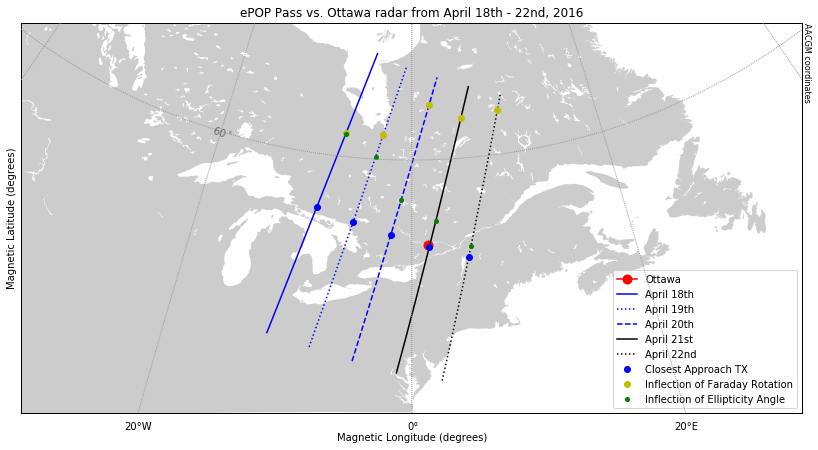

In [5]:
from ottawa_plots import *
def plot_all5():
    """
    Plot April 18th-22nd ephemeris tracks on same mapobj
    """
    fname_18th, idx_rev_18th, ellip_rev_18th = get_ottawa_data2("20160418")
    lons_18th, lats_18th, alts_18th, ephtimes_18th = get_rri_ephemeris(fname_18th)
    fname_19th, idx_rev_19th, ellip_rev_19th = get_ottawa_data2("20160419")
    lons_19th, lats_19th, alts_19th, ephtimes_19th = get_rri_ephemeris(fname_19th)
    fname_20th, idx_rev_20th, ellip_rev_20th = get_ottawa_data2("20160420")
    lons_20th, lats_20th, alts_20th, ephtimes_20th = get_rri_ephemeris(fname_20th)
    fname_21st, idx_rev_21st, ellip_rev_21st = get_ottawa_data2("20160421")
    lons_21st, lats_21st, alts_21st, ephtimes_21st = get_rri_ephemeris(fname_21st)
    fname_22nd, idx_rev_22nd, ellip_rev_22nd = get_ottawa_data2("20160422")
    lons_22nd, lats_22nd, alts_22nd, ephtimes_22nd = get_rri_ephemeris(fname_22nd)
    
    times_18th = ephems_to_datetime(ephtimes_18th)
    times_19th = ephems_to_datetime(ephtimes_19th)
    times_20th = ephems_to_datetime(ephtimes_20th)
    times_21st = ephems_to_datetime(ephtimes_21st)
    times_22nd = ephems_to_datetime(ephtimes_22nd)

    indx_shortest_18th, dists_18th = get_closest_ottawa_approach(lons_18th, lats_18th, alts_18th)
    indx_shortest_19th, dists_19th = get_closest_ottawa_approach(lons_19th, lats_19th, alts_19th)
    indx_shortest_20th, dists_20th = get_closest_ottawa_approach(lons_20th, lats_20th, alts_20th)
    indx_shortest_21st, dists_21st = get_closest_ottawa_approach(lons_21st, lats_21st, alts_21st)
    indx_shortest_22nd, dists_22nd = get_closest_ottawa_approach(lons_22nd, lats_22nd, alts_22nd)
    
    # The numeric data type that I was retrieving from geog_longs, when _NOT_ stored
    # in an array, was being rejected by the mapObj() function below. So I convert 
    # these numbers to floats explicitly here.
    shlon_18th = float(lons_18th[indx_shortest_18th])
    shlat_18th = float(lats_18th[indx_shortest_18th])
    invlon_18th = float(lons_18th[idx_rev_18th])
    invlat_18th = float(lats_18th[idx_rev_18th])
    elliplon_18th = float(lons_18th[ellip_rev_18th])
    elliplat_18th = float(lats_18th[ellip_rev_18th])
 
    shlon_19th = float(lons_19th[indx_shortest_19th])
    shlat_19th = float(lats_19th[indx_shortest_19th])
    invlon_19th = float(lons_19th[idx_rev_19th])
    invlat_19th = float(lats_19th[idx_rev_19th])
    elliplon_19th = float(lons_19th[ellip_rev_19th])
    elliplat_19th = float(lats_19th[ellip_rev_19th])

    shlon_20th = float(lons_20th[indx_shortest_20th])
    shlat_20th = float(lats_20th[indx_shortest_20th])
    invlon_20th = float(lons_20th[idx_rev_20th])
    invlat_20th = float(lats_20th[idx_rev_20th])
    elliplon_20th = float(lons_20th[ellip_rev_20th])
    elliplat_20th = float(lats_20th[ellip_rev_20th])

    shlon_21st = float(lons_21st[indx_shortest_21st])
    shlat_21st = float(lats_21st[indx_shortest_21st])
    invlon_21st = float(lons_21st[idx_rev_21st])
    invlat_21st = float(lats_21st[idx_rev_21st])
    elliplon_21st = float(lons_21st[ellip_rev_21st])
    elliplat_21st = float(lats_21st[ellip_rev_21st])

    shlon_22nd = float(lons_22nd[indx_shortest_22nd])
    shlat_22nd = float(lats_22nd[indx_shortest_22nd])
    invlon_22nd = float(lons_22nd[idx_rev_22nd])
    invlat_22nd = float(lats_22nd[idx_rev_22nd])
    elliplon_22nd = float(lons_22nd[ellip_rev_22nd])
    elliplat_22nd = float(lats_22nd[ellip_rev_22nd])
   
    # A different font for the legend etc. might be nice
    fig = plt.figure(1, figsize=(14,8))
    font = {'fontname':'Computer Modern'}
    #m = plotUtils.mapObj(lat_0=45.0, lon_0=-75.0, width=50e3*180, height=40e3*90, coords='geo',resolution='i',datetime=times_20th[0])
    m = plotUtils.mapObj(lat_0=57.0, lon_0=0.0, width=25e3*180, height=25e3*90, coords='mag',resolution='i',datetime=times_20th[0])

    # FIRST: Plot the location of Ottawa
    x,y = m(OTTAWA_TX_LON,OTTAWA_TX_LAT,coords='geo')
    m.plot(x,y,'r-o',markersize=9,label="Ottawa")
    
    # SECOND: Plot the satellite ground-track.
    x,y = m(lons_18th, lats_18th, coords='geo')
    m.plot(x,y,'b-',label="April 18th")#label="EPOP ground track")
    x,y = m(lons_19th, lats_19th, coords='geo')
    m.plot(x,y,'b:',label="April 19th")
    x,y = m(lons_20th, lats_20th, coords='geo')
    m.plot(x,y,'b--',label="April 20th")
    x,y = m(lons_21st, lats_21st, coords='geo')
    m.plot(x,y,'k-',label="April 21st")
    x,y = m(lons_22nd, lats_22nd, coords='geo')
    m.plot(x,y,'k:',label="April 22nd")
    
    # THIRD: Plot a circle emphasizing the point of closest approach
    x,y = m(shlon_18th, shlat_18th, coords='geo')
    m.plot(x,y,'bo',label='Closest Approach TX')
    x,y = m(shlon_19th, shlat_19th, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_20th, shlat_20th, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_21st, shlat_21st, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_22nd, shlat_22nd, coords='geo')
    m.plot(x,y,'bo')

    # FOURTH: Plot the piont I've determined is the point of the Faraday Rotation inversion.
    x,y = m(invlon_18th, invlat_18th, coords='geo')
    m.plot(x,y,'yo',markersize=6,label=("Inflection of Faraday Rotation"))
    x,y = m(invlon_19th, invlat_19th, coords='geo')
    m.plot(x,y,'yo')
    x,y = m(invlon_20th, invlat_20th, coords='geo')
    m.plot(x,y,'yo')
    x,y = m(invlon_21st, invlat_21st, coords='geo')
    m.plot(x,y,'yo')
    x,y = m(invlon_22nd, invlat_22nd, coords='geo')
    m.plot(x,y,'yo')

    # FIFTH: Plot the point we've determined to be the ellipticity reversal
    x,y = m(elliplon_18th, elliplat_18th, coords='geo')
    m.plot(x,y,'go',markersize=4,label=("Inflection of Ellipticity Angle"))
    x,y = m(elliplon_19th, elliplat_19th, coords='geo')
    m.plot(x,y,'go',markersize=4)
    x,y = m(elliplon_20th, elliplat_20th, coords='geo')
    m.plot(x,y,'go',markersize=4)
    x,y = m(elliplon_21st, elliplat_21st, coords='geo')
    m.plot(x,y,'go',markersize=4)
    x,y = m(elliplon_22nd, elliplat_22nd, coords='geo')
    m.plot(x,y,'go',markersize=4)

    # FIFTH: a few lines of magnetic longitude and latitude will be plotted as well.
    #N = 10
    #latdivs = 90./N
    #londivs = 360./N
    #for n in range(N):
    #    merid_mlat = np.arange(181) - 90.
    #    merid_mlon = merid_mlat*0 - n*londivs
    #    paral_mlon = np.arange(361) - 180.
    #    paral_mlat = paral_mlon*0. + n*latdivs
    #    x,y = m(merid_mlon, merid_mlat, coords='mag')
    #    if n == 0:
    #        m.plot(x,y,'k',label="Magnetic Longitude and Latitude")
    #        continue
    #    m.plot(x,y,'k')#,label="Line of Magnetic Longitude of -20 Degrees")
    #    x,y = m(paral_mlon, paral_mlat, coords='mag')
    #    m.plot(x,y,'k')#,label="Line of Magnetic Latitude of +75 Degrees")
    ax = plt.gca()
    ax.set_xlabel('Magnetic Longitude (degrees)')
    ax.xaxis.set_label_coords(0.5,-0.050)
    #plt.xlabel('Magnetic Longitude (degrees)')
    plt.ylabel('Magnetic Latitude (degrees)')
    plt.title("ePOP Pass vs. Ottawa radar from April 18th - 22nd, 2016")
    plt.legend(loc='lower right', numpoints = 1)#loc='best')
    plt.savefig('tmp_all5.eps', format='eps', bbox_inches='tight')
    plt.savefig('tmp_all5.png', format='png', bbox_inches='tight')
    plt.show()
 
plot_all5()

## Plotting the Ottawa Passes from only the 18th and the 22nd
In the past it's been worth plotting not all 5 Ottawa passes, but just the first and the last.

In [63]:
def plot_1822():
    """
    Plot April 18th and 22nd ephemeris tracks on same mapobj
    """
    # TODO: fixup this documentation
    date_string="20160418"
       
    fname,index_reversal,ellip_reversal = get_ottawa_data2(date_string)
    geog_longs,geog_lats,alts,ephemtimes = get_rri_ephemeris(fname)

    fname_22nd, idx_rev_22nd, ellip_reversal_22nd = get_ottawa_data2("20160422")
    lons_22nd, lats_22nd, alts_22nd, ephtimes_22nd = get_rri_ephemeris(fname_22nd)

    times = ephems_to_datetime(ephemtimes)
    times_22nd = ephems_to_datetime(ephtimes_22nd)

    indx_shortest, dists = get_closest_ottawa_approach(geog_longs, geog_lats, alts)
    appr_time = times[indx_shortest]

    indx_shortest_22nd, dists_22nd = get_closest_ottawa_approach(lons_22nd, lats_22nd, alts_22nd)
    appr_time_22nd = times_22nd[indx_shortest_22nd]
    
    # The numeric data type that I was retrieving from geog_longs, when _NOT_ stored
    # in an array, was being rejected by the mapObj() function below. So I convert 
    # these numbers to floats explicitly here.
    shortest_ephem_long = float(geog_longs[indx_shortest])
    shortest_ephem_lat = float(geog_lats[indx_shortest])
    inversion_ephem_long = float(geog_longs[index_reversal])
    inversion_ephem_lat = float(geog_lats[index_reversal])
    elliplon_18th = float(geog_longs[ellip_reversal])
    elliplat_18th = float(geog_lats[ellip_reversal])

    elliplon_22nd = float(lons_22nd[ellip_reversal_22nd])
    elliplat_22nd = float(lats_22nd[ellip_reversal_22nd])
    shlon_22nd = float(lons_22nd[indx_shortest])
    shlat_22nd = float(lats_22nd[indx_shortest])
    invlon_22nd = float(lons_22nd[index_reversal])
    invlat_22nd = float(lats_22nd[index_reversal])
    
    # A different font for the legend etc. might be nice
    fig = plt.figure(1, figsize=(14,8))
    font = {'fontname':'Computer Modern'}
    #m = plotUtils.mapObj(lat_0=45.0, lon_0=-75.0, width=60e3*180, height=50e3*90, coords='geo', resolution='i',datetime=times[0])
    m = plotUtils.mapObj(lat_0=57.0, lon_0=0.0, width=25e3*180, height=25e3*90, coords='mag', resolution='i', datetime=times[0])

    # FIRST: Plot the location of Ottawa
    x,y = m(OTTAWA_TX_LON,OTTAWA_TX_LAT,coords='geo')
    m.plot(x,y,'r-o',markersize=9,label="Ottawa")
    
    # SECOND: Plot the satellite ground-track.
    # Day of 18th
    x,y = m(geog_longs, geog_lats, coords='geo')
    m.plot(x,y,'b',label="EPOP ground track")
    # Day of 22nd
    x,y = m(lons_22nd, lats_22nd, coords='geo')
    m.plot(x,y,'b')
    
    # THIRD: Plot a circle emphasizing the point of closest approach
    x,y = m(shortest_ephem_long,shortest_ephem_lat, coords='geo')
    m.plot(x,y,'bo')
    x,y = m(shlon_22nd, shlat_22nd, coords='geo')
    m.plot(x,y,'bo',label=("Closest Approach TX"))

    # FOURTH: Plot the line from Ottawa to the nearest approach of the satellite.
    x,y = m([shortest_ephem_long, OTTAWA_TX_LON], [shortest_ephem_lat, OTTAWA_TX_LAT], coords='geo')
    m.plot(x,y,'g')
    x,y = m([shlon_22nd, OTTAWA_TX_LON], [shlat_22nd, OTTAWA_TX_LAT], coords='geo')
    m.plot(x,y,'g')
    
    
    # FIFTH: Plot the piont I've determined is the point of the Faraday Rotation inversion.
    x,y = m(inversion_ephem_long,inversion_ephem_lat,coords='geo')
    m.plot(x,y,'yo',label=("Inflection of Faraday Rotation"))
    x,y = m(invlon_22nd, invlat_22nd, coords='geo')
    m.plot(x,y,'yo')

    # SIXTH: Plot the point we've determined to be the ellipticity reversal
    x,y = m(elliplon_18th, elliplat_18th, coords='geo')
    m.plot(x,y,'go',markersize=4,label=("Inflection of Ellipticity Angle"))
    x,y = m(elliplon_22nd, elliplat_22nd, coords='geo')
    m.plot(x,y,'go',markersize=4)

    # SEVENTH: GET IGRF DATA FOR EACH EPHEMERIS POINT
    """
    itype = 1 #Geodetic coordinates
    pyDate = times[0] # The first time we pull from the RRI file
    date = utils.dateToDecYear(pyDate) # decimal year
    alt = 300. # altitude #TODO: grab altitudes for series of satellite positions we care about.
    stp = 1. #
    xlti, xltf, xltd = OTTAWA_TX_LAT, OTTAWA_TX_LAT,stp # latitude start, stop, step
    xlni, xlnf, xlnd = OTTAWA_TX_LON, OTTAWA_TX_LON,stp # longitude start, stop, step
    ifl = 0 # Main field
    # Call fortran subroutine
    lat,lon,d,s,h,x,y,z,f = igrf.igrf11(itype,date,alt,ifl,xlti,xltf,xltd,xlni,xlnf,xlnd)
    """
    ax = plt.gca()
    ax.set_xlabel('Magnetic Longitude (degrees)')
    ax.xaxis.set_label_coords(0.5,-0.050)
    #plt.xlabel('Magnetic Longitude (degrees)')
    plt.ylabel('Magnetic Latitude (degrees)')
    plt.title("ePOP Pass vs. Ottawa radar on April 18th, 2016 (left) and April 22nd, 2016 (right)")
    plt.legend(loc='lower right', numpoints = 1)#loc='best')
    
    plt.savefig('tmp_1822.eps', format='eps', bbox_inches='tight')
    plt.savefig('tmp_1822.png', format='png', bbox_inches='tight')
    plt.show()
    
plot_1822()

AttributeError: 'AxesSubplot' object has no attribute 'get_facecolor'

## Plotting the RRI Dipole Antenna's orientation 
[with respect to incident radio waves from Ottawa transmitter, currently]

In [ ]:
def plot_kdip_angle(date_string):
    """
    Plots the angle between the k_LOS vector and the dip_dir vector. 
    If they were perfectly matched, we would expect exactly 180 degrees.
    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    dipole_dirs, kdip_angles = get_kdip_angles(lons,lats,alts,ephtimes,pitch,yaw,roll)
    #plot_kb_angle(date_string)
    #plot_kvec(date_string)
    #plot_ramdir("20160418")
    #fig = plt.figure()
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom=0.2)
    plt.plot(kdip_angles)
    ephem_ticks(lons,lats,alts,ephtimes,mlons,mlats,mlts)
    plt.ylabel('Angle (degrees)')
    plt.title('Plot of angle between K_los from Ottawa transmitter and Dipole direction of RRI for ' + date_string)
    plt.show()
    
plot_kdip_angle("20160418")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5,forward=True)

## Plotting Ram Directions from an RRI Dataset
Sometimes it's worth getting a view of the ram direction of CASSIOPE as it proceeds through its orbit and its orientation with respect to the magnetic field or ground stations changes.


In [ ]:
def plot_ramdir(date_string):
    """
    Makes a 3D plot of the ram direction components at each ephemeris point for
    the given date.  
    """
    datname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(datname)
    vs,dists = get_ramdirs(lons,lats,alts,ephtimes)   
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = Axes3D(fig)
    vx = [v[0] for v in vs]
    vy = [v[1] for v in vs]
    vz = [v[2] for v in vs]
    Axes3D.plot(ax,vx,vy,zs=vz)
    plt.xlabel("Vx direction - North (km/s)")
    plt.ylabel("Vy direction - East (km/s)")
    ax.set_zlabel("-Vz direction - Up (km/s)")
    plt.title("Change of V vector components during RRI pass on " + str(date_string))
    plt.show() 
    
plot_ramdir("20160418")

## Plotting K_los Vector
The line of sight vector from a nearby transmitter to the satellite gives a sense of what the radio wave's Poynting vector orientation would be, which is useful for analyzing its orientation with respect to the magnetic field of the Earth or its orientation with respect to the satellite itself.

In [ ]:
def plot_kvec(date_string):
    """
    A function for visualizing the k-vector's time evolution throughout a 
    pass of EPOP.

    *** PARAMS ***
    date_string (string): string in form "20160418" to denote date for which to plot KB angle

    *** RETURNS ***
    - (just plots)

    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    bvecs,kvecs,angles = get_kb_ottawa_angle(lons,lats,alts,ephtimes)
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    dt_t  = times[0]
    alt_t = alts[0]
    lon_t = lons[0]
    lat_t = lats[0]
    mlon_t = mlons[0]
    mlat_t = mlats[0]
    mlt_t = mlts[0]
    dist_t = dists[0]
    my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
        "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = lons[tick_sep*(i+1)]
        lat_t = lats[tick_sep*(i+1)]
        mlon_t = mlons[tick_sep*(i+1)]
        mlat_t = mlats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        mlt_t = mlts[tick_sep*(i+1)]
        dist_t = dists[tick_sep*(i+1)]
        my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
                "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    
    indices = range(angles.__len__())
    tick_indices = [i*tick_sep for i in range(num_ticks)]
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = Axes3D(fig)
    kx = [kv[0] for kv in kvecs]
    ky = [kv[1] for kv in kvecs]
    kz = [kv[2] for kv in kvecs]
    Axes3D.plot(ax,kx,ky,zs=kz)
    plt.xlabel("Kx direction (North)")
    plt.ylabel("Ky direction (East)")
    ax.set_zlabel("Kz direction (Down)")
    plt.title("Change of K vector components during RRI pass on " + str(date_string))
    plt.show() 
    
plot_kvec("20160418")

## Plotting Normalized K_los vector and B vector
If each of these vectors are normalized, the distance between corresponding points is proportional to cos(theta) for the angle theta between the vectors (aspect angle).


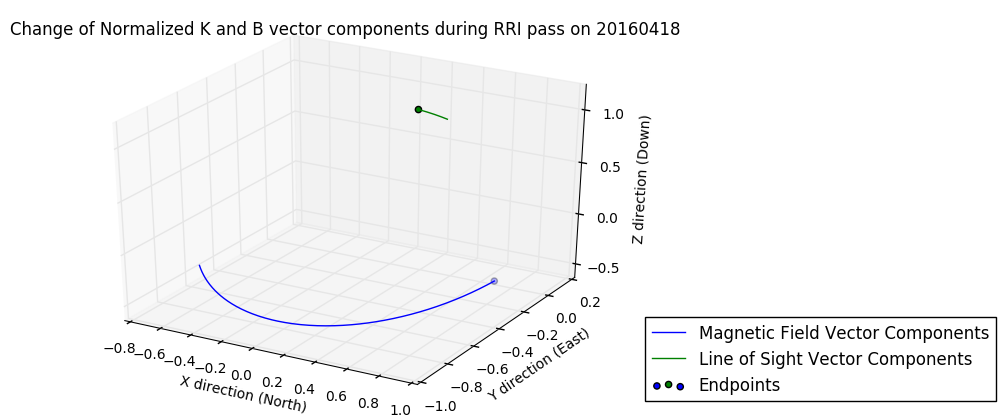

In [87]:
def plot_k_b(date_string):
    """
    A function for visualizing the b-field and line of sight vector's time evolution throughout a pass of EPOP.

    *** PARAMS ***
    date_string (string): string in form "20160418" to denote date for which to plot KB angle

    *** RETURNS ***
    - (just plots)

    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    bvecs,kvecs,angles = get_kb_ottawa_angle(lons,lats,alts,ephtimes)
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    """
    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    dt_t  = times[0]
    alt_t = alts[0]
    lon_t = lons[0]
    lat_t = lats[0]
    mlon_t = mlons[0]
    mlat_t = mlats[0]
    mlt_t = mlts[0]
    dist_t = dists[0]
    my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
        "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = lons[tick_sep*(i+1)]
        lat_t = lats[tick_sep*(i+1)]
        mlon_t = mlons[tick_sep*(i+1)]
        mlat_t = mlats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        mlt_t = mlts[tick_sep*(i+1)]
        dist_t = dists[tick_sep*(i+1)]
        my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
                "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    """
    
    indices = range(angles.__len__())
    tick_indices = [i*tick_sep for i in range(num_ticks)]
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = Axes3D(fig)
    norm_b = np.array([ b/np.linalg.norm(b) for b in bvecs])
    norm_k = np.array([ k/np.linalg.norm(k) for k in kvecs])
    norm_kx = [kv[0] for kv in norm_k]
    norm_ky = [kv[1] for kv in norm_k]
    norm_kz = [kv[2] for kv in norm_k]
    norm_bx = [bv[0] for bv in norm_b]
    norm_by = [bv[1] for bv in norm_b]
    norm_bz = [bv[2] for bv in norm_b]
    angle_dists = np.array([ np.linalg.norm(norm_b[i] - norm_k[i]) for i in range(len(norm_b))])
    angles = np.degrees(np.arccos(1 - (angle_dists**2)/2))
    #print angles
    Axes3D.scatter(ax,[norm_kx[-1],norm_bx[-1]],[norm_ky[-1],norm_by[-1]],zs=[norm_kz[-1],norm_bz[-1]],c=['b','g'],label='Endpoints')
    Axes3D.plot(ax, norm_kx, norm_ky, zs=norm_kz,label="Magnetic Field Vector Components")
    Axes3D.plot(ax, norm_bx, norm_by, zs=norm_bz,label="Line of Sight Vector Components")
    plt.xlabel("X direction (North)")
    plt.ylabel("Y direction (East)")
    ax.set_zlabel("Z direction (Down)")
    plt.legend(numpoints=1,bbox_to_anchor=(1., 0.02, 1., .102), loc=3, borderaxespad=0.)
    plt.title("Change of Normalized K and B vector components during RRI pass on " + str(date_string))
    plt.show() 
    
plot_k_b("20160418")

## Plotting Estimated Aspect Angle
By taking the line of sight vector and comparing to the Earth's magnetic field orientation at various positions, the aspect angle of the wave as it passes through the density peak of the ionosphere can be inferred.

5


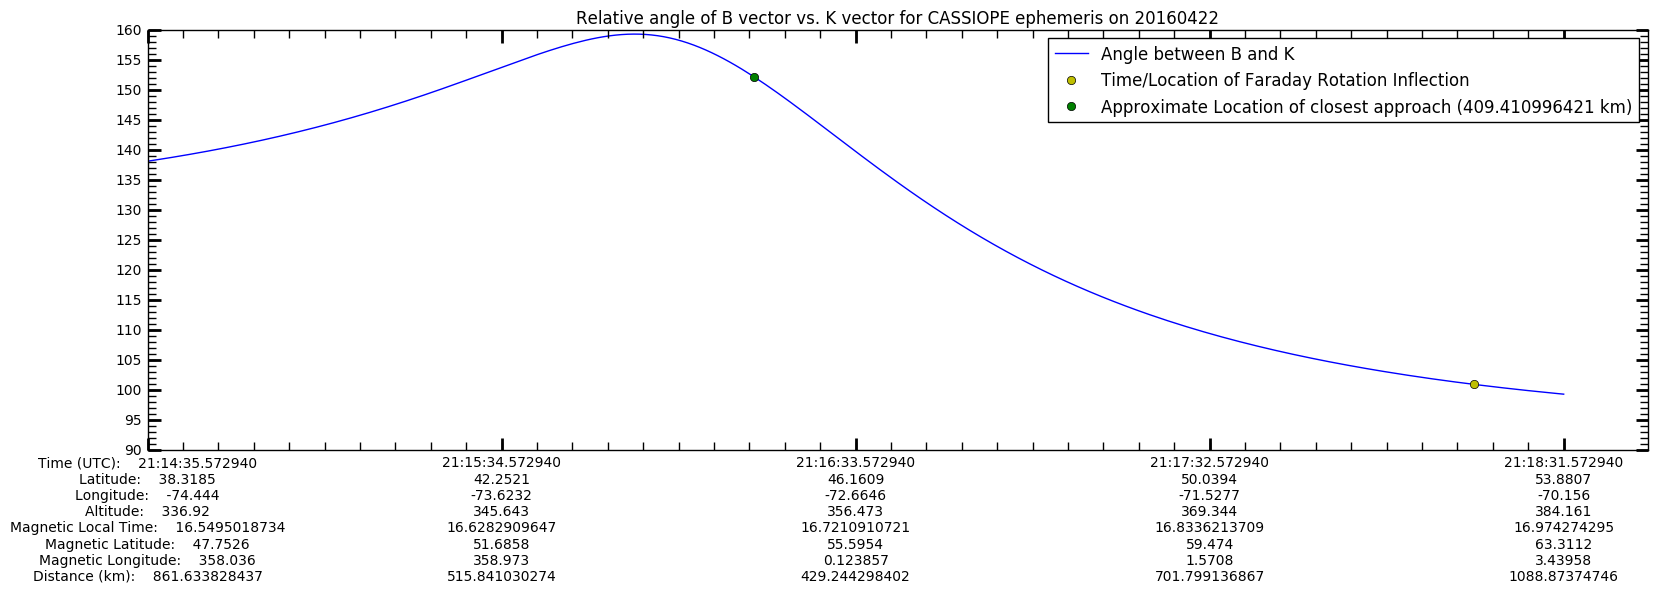

In [88]:
def plot_kb_angle(date_string,save_plots=False):
    """
    Take date_string as input, produce kb-angle as output 

    *** PARAMS ***
    date_string (string): string in form "20160418" to denote date for which to plot KB angle

    *** RETURNS ***
    - (just plots)
    

    """
    fname,index_reversal = get_ottawa_data(date_string)
    lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
    bvecs,kvecs,angles = get_kb_ottawa_angle(lons,lats,alts,ephtimes)
    indx_closest, dists = get_closest_ottawa_approach(lons,lats,alts)
    times = ephems_to_datetime(ephtimes)
    
    my_xticks = []
    num_ticks = 5
    length = times.__len__()
    tick_sep = length/(num_ticks - 1)
    dt_t  = times[0]
    alt_t = alts[0]
    lon_t = lons[0]
    lat_t = lats[0]
    mlon_t = mlons[0]
    mlat_t = mlats[0]
    mlt_t = mlts[0]
    dist_t = dists[0]
    my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
        "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))
    for i in range(num_ticks-1):
        alt_t = alts[tick_sep*(i+1)]
        lon_t = lons[tick_sep*(i+1)]
        lat_t = lats[tick_sep*(i+1)]
        mlon_t = mlons[tick_sep*(i+1)]
        mlat_t = mlats[tick_sep*(i+1)]
        dt_t  = times[tick_sep*(i+1)]
        mlt_t = mlts[tick_sep*(i+1)]
        dist_t = dists[tick_sep*(i+1)]
        my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
                "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    
    indices = range(angles.__len__())
    tick_indices = [i*tick_sep for i in range(num_ticks)]
    
    # Formatting adjustment so as to make room for the lengthy Ephemeris info
    fig = plt.figure(figsize=(20.5, 6))
    ax = plt.subplot(111,aspect = 'equal')
    plt.subplots_adjust(bottom=0.2)

    
    plt.plot(indices,angles,label="Angle between B and K")
    delta = int(max(angles) - min(angles))
    offs = min(angles)
    plt.plot(index_reversal,angles[index_reversal],'yo',label="Time/Location of Faraday Rotation Inflection")
    plt.plot(indx_closest,angles[indx_closest],'go',label="Approximate Location of closest approach (" + str(dists[indx_closest]) + " km)")
    plt.title("Relative angle of B vector vs. K vector for CASSIOPE ephemeris on " + str(date_string))
    #plt.xlabel('Time elapsed during pass (seconds)')
    plt.xticks(tick_indices, my_xticks)
    
    # Minor ticks
    small_xticks = np.arange(0,len(indices),(tick_sep/10.))
    print len(tick_indices)
    ax.set_xticks(small_xticks, minor = True)
    ax.tick_params(which='minor',length=6,width=1)
    ax.tick_params(which='major',length=9,width=2)
    import matplotlib.ticker as ticker
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    plt.legend(numpoints=1)
    if save_plots==False:
        plt.show()
    else:
        plt.savefig("aspect_angle_"+str(date_string)+".png")
    
plt.figure(figsize=(12,8))
plot_kb_angle("20160422",save_plots=False)
#fig = plt.gcf()
#fig.set_size_inches(20.5, 6,forward=True)

## Plots of indices of refraction for various aspect angles
By determining cyclotron frequency and plasma frequency of a point in an ionospheric plasma medium, the Appleton-Hartree Equation's X, Y, and Z coefficients can be computed and the equation itself can be solved for the indices of refraction n_plus and n_minus.


In [61]:
def compare_QL_QT(freq,omega_c,omega_p,label="",saveplots=False):
    """
    It comes in handy to study the propagation mode of a radio wave in the 
    ionospheric plasma medium sometimes.
 
    *Params*:
        
        [freq_label]: String describing radio wave frequency (e.g. "50 MHz")
    """
    theta = np.array( range(3141) )/1000.
    X,Y,Z = appleton_coeffs(omega_c,omega_p,freq,0.0)
    yt = Y*np.sin(theta)
    yl = Y*np.cos(theta)
    qt_term = (yt**4)/(4*((1 - X - 1j*Z)**2))    
    ql_term = yl**2
    plt.plot(theta*180/np.pi, ql_term, label="YL Term")
    plt.plot(theta*180/np.pi, qt_term, label="YT Term")
    if label=="":
        label="Relative Strength of QL and QT Mode Propagation Terms"
    plt.title(label)
    plt.xlim((65, 115))
    plt.ylim((0, ql_term[int(3141*115/180.)]))
    plt.xlabel("Aspect Angle, Theta, [degrees]")
    plt.ylabel("Y_L and Y_T terms, [dimensionless]")
    plt.legend()
    if saveplots==False:
        plt.show()
    else:
        plt.savefig('qlqt_terms_'+str(freq)+'.png')
    return ql_term,qt_term,Y

def plot_appleton_hartree(freq, omega_c, omega_p, altitude=300.,label="",saveplots=False):
    """
    A stand-alone function taking an altitude (within the ionosphere) and a frequency
    and plotting the Appleton-Hartree indices of refraction of the ionospheric plasma.

    *Params*:
        freq: Frequency numeric type (in [Hz]) for calculating parameters

    """
    X,Y,Z = appleton_coeffs(omega_c,omega_p,freq,0.0)
    theta = np.array( range(315) )/100. # Approximately 0 to pi
    print ("X: ",X,"Y: ",Y,"Z: ",Z)
    np_sq,nm_sq = appleton_hartree(X,Y,Z,theta)
    nplus = np.sqrt(np_sq)
    nminus = np.sqrt(nm_sq)
    plt.plot(theta*180./np.pi,nplus,'b',label="+ from +/-")
    plt.plot(theta*180./np.pi,nminus,'r',label="- from +/-")
    if label=="":
        label = "Indices of refraction of an HF radio wave in ionosphere vs aspect angle"
    plt.title(label)
    plt.xlabel("Aspect Angle, Theta, [degrees]")
    plt.ylabel("Index of Refraction, n, [dimensionless]")
    plt.legend()
    if saveplots==False:
        plt.show()
    else:
        plt.savefig('indices_ref_'+str(freq)+'.png')

        
date_str = "20160420"
fof2 = 5.381E6

filename, __ = get_ottawa_data(date_str)
title_str1="Indices of Refraction vs. Aspect Angle at the f0f2 peak for the " + date_str + " RRI Experiment"
title_str2="Relative Strength of QL and QT Appleton-Hartree Terms at the f0f2 peak for the " + date_str + " RRI Experiment"

freq10 = 1.0422E7
lons,lats,alts,ephtimes = data_utils.get_rri_ephemeris(filename)
# hack to compute only B fields corresponding to the f0f2 peak altitude
alts = np.array([ 250. for alt in alts ])
b_igrf = magnet_data.get_igrf(lons,lats,alts,ephtimes)
omega_c = improved_cyclotron_freq(lons,lats,alts,ephtimes)
omega_p = fof2*(2*np.pi)

print ("Omega_c: ", omega_c,"omega_p: ",omega_p, "frequency: ",freq10)
plt.figure(figsize=(12,8))
plot_appleton_hartree(freq10, omega_c, omega_p, label=title_str1,saveplots=True)
# COMPARE QL VS QT MODE TERMS AT TWO FREQUENCIES
#plt.figure()
plt.figure(figsize=(12,8))
ql_term10, qt_term10, Y10 = compare_QL_QT(freq10, omega_c, omega_p, label=title_str2,saveplots=True)

('Omega_c: ', 8504428.8879877869, 'omega_p: ', 33809820.13793335, 'frequency: ', 10422000.0)
('X: ', 0.26657771831070043, 'Y: ', 0.12987160772373507, 'Z: ', 0.0)



## Plots of indices of refraction during an ePOP pass
Sometimes it's valuable to plot the indices of refraction corresponding to the plasma frequency peak (fof2 peak) in the ionosphere at that time.

For a user-provided plasma frequency and corresponding altitude (consult with ionograms e.g. from DIDBase to see the fof2 peak that day), the indices of refraction at the plasma density peak can be computed for a set of satellite ephemeris points with respect to a transmitter. 


[0, 59, 118, 177, 236]
873.228716824
515.912606819
405.292901615
673.238532726
1062.35141599
5


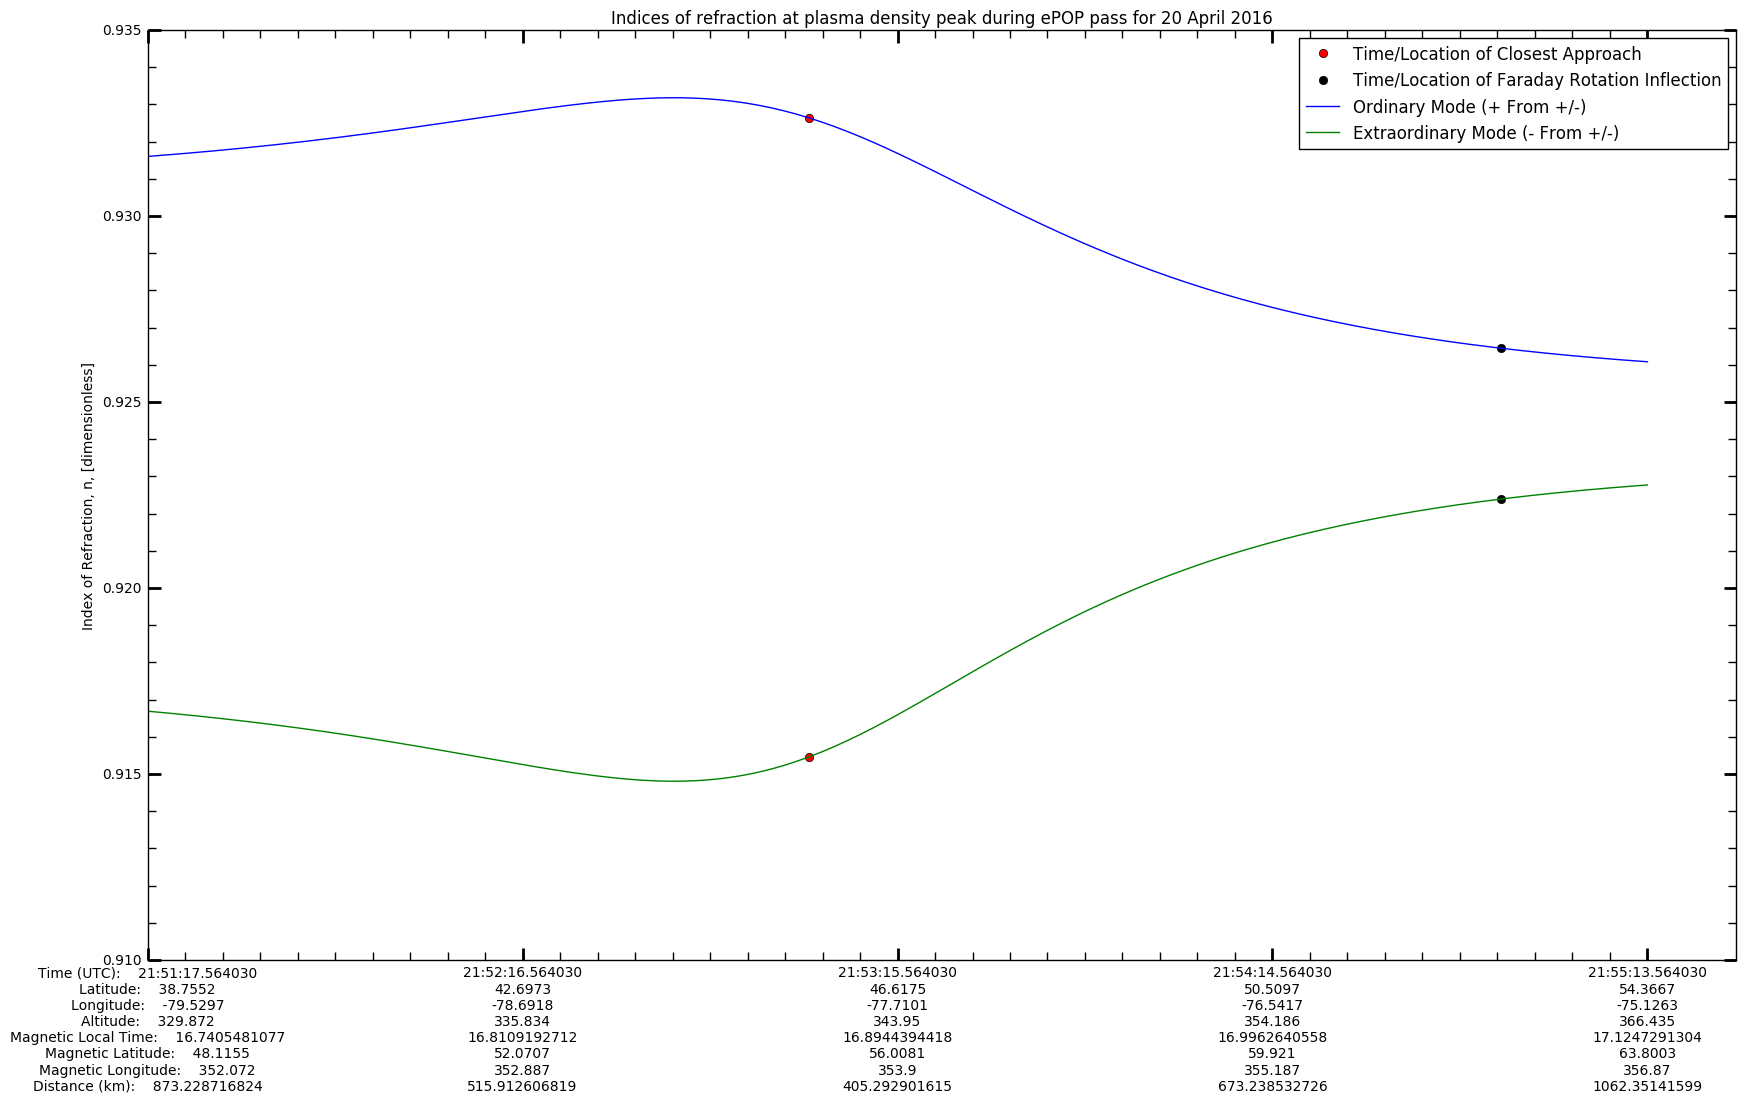

In [60]:
# To change the day to analyze, change: 
# i) get_ottawa_data below, ii) omega_p's value, iii) title, iv) fof2_alt optional parameter in txpass_to_indices
date_string = "20160420" # for get_ottawa_data to grab RRI file and corresponding data
fof2 = 5.381E6 # for omega_p
fof2_altitude = 260.
title_str = "Indices of refraction at plasma density peak during ePOP pass for 202 April 2016"



fname,index_reversal = get_ottawa_data(date_string)
lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
times = ephems_to_datetime(ephtimes)
omega_p = fof2*(2*np.pi)
tx_lon = -75.552
tx_lat = 45.403
freq = 1.0422E7 # [Hz] 
omega_c = improved_cyclotron_freq(lons,lats,alts,ephtimes,fof2_alt=fof2_altitude)
angs,nplus,nminus = txpass_to_indices(lons,lats,alts,ephtimes,tx_lon,tx_lat,freq,omega_p,omega_c)
index_closest, dists = get_closest_ottawa_approach(lons,lats,alts)                                       

# Ephemeris ticks stuff
my_xticks = []
num_ticks = 5
length = times.__len__()
tick_sep = length/(num_ticks - 1)
dt_t  = times[0]
alt_t = alts[0]
lon_t = lons[0]
lat_t = lats[0]
mlon_t = mlons[0]
mlat_t = mlats[0]
mlt_t = mlts[0]
dist_t = dists[0]
dists.append(dists[-1]) # hacky way to pad dists to same length as others
my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
    "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))

indices = range(nplus.__len__())
tick_indices = [i*tick_sep for i in range(num_ticks)]
print tick_indices

for i,e in enumerate(tick_indices):
    print dists[e]
    if i==0:
        continue
    alt_t = alts[e]
    lon_t = lons[e]
    lat_t = lats[e]
    mlon_t = mlons[e]
    mlat_t = mlats[e]
    dt_t  = times[e]
    mlt_t = mlts[e]
    dist_t = dists[e]
    my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
        "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    

# Code block for performing plotting (once above block's variables have been defined)

saveplots=True

# Points for marking the faraday rotation inflection location
num = 40
maxNP = max(np.real(nplus))
minNM = min(np.real(nminus))
delta = abs(maxNP - minNM)

# Formatting adjustment so as to make room for the lengthy Ephemeris info
fig = plt.figure(figsize=(20.5, 12))
ax = fig.add_subplot(111)
#ax = plt.subplot(111,aspect = 'equal')
#plt.subplots_adjust(bottom=0.2)

#x = (index_reversal)*np.ones(num)
#y = np.array(range(num))/(40.)*delta + minNM
#ax.plot(x,y,'y',label="Time/Location of Faraday Rotation Inflection")
ax.plot(index_closest,nplus[index_closest],'ro',label="Time/Location of Closest Approach")
ax.plot(index_closest,nminus[index_closest],'ro')
ax.plot(index_reversal,nplus[index_reversal],'ko')
ax.plot(index_reversal,nminus[index_reversal],'ko',label="Time/Location of Faraday Rotation Inflection")
ax.plot(indices,nplus,label="Ordinary Mode (+ From +/-)")
ax.plot(indices,nminus,label="Extraordinary Mode (- From +/-)")
plt.title(title_str)
#plt.xlabel("Time into pass [s]")
plt.ylabel("Index of Refraction, n, [dimensionless]")
plt.xticks(tick_indices, my_xticks) # Setting labeled ticks

# Minor ticks
small_xticks = np.arange(0,len(indices),(tick_sep/10.))
print len(tick_indices)
ax.set_xticks(small_xticks, minor = True)
ax.tick_params(which='minor',length=6,width=1)
ax.tick_params(which='major',length=9,width=2)

import matplotlib.ticker as ticker
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
ax.legend(numpoints=1)

# Save or show
if saveplots==True:
    plt.savefig('applhar_tmp'+str(freq)+'.png')
plt.show()




In [1]:
# To change the day to analyze, change: 
# i) get_ottawa_data below, ii) omega_p's value, iii) title, iv) fof2_alt optional parameter in txpass_to_indices
date_string = "20160420" # for get_ottawa_data to grab RRI file and corresponding data
fof2 = 5.381E6 # for omega_p
fof2_altitude = 260.
saveplots=True

# Loading, computing, and defining statistics of the pass
fname,index_reversal = get_ottawa_data(date_string)
lons,lats,alts,ephtimes,mlons,mlats,mlts,pitch,yaw,roll = get_rri_ephemeris_full(fname)
bvecs,kvecs,angles = get_kb_ottawa_angle(lons,lats,alts,ephtimes)
times = ephems_to_datetime(ephtimes)
omega_p = fof2*(2*np.pi)
tx_lon = -75.552 #[deg]
tx_lat = 45.403 # [deg]
freq = 1.0422E7 # [Hz] 
omega_c = improved_cyclotron_freq(lons,lats,alts,ephtimes,fof2_alt=fof2_altitude)
angs,nplus,nminus = txpass_to_indices(lons,lats,alts,ephtimes,tx_lon,tx_lat,freq,omega_p,omega_c)
index_closest, dists = get_closest_ottawa_approach(lons,lats,alts)                                       

# Ephemeris ticks stuff
my_xticks = []
num_ticks = 6
length = times.__len__()
tick_sep = length/(num_ticks - 1)
dt_t  = times[0]
alt_t = alts[0]
lon_t = lons[0]
lat_t = lats[0]
mlon_t = mlons[0]
mlat_t = mlats[0]
mlt_t = mlts[0]
dist_t = dists[0]
dists.append(dists[-1]) # hacky way to pad dists to same length as others
my_xticks.append("Time (UTC):    "+str(dt_t.time())+"\nLatitude:    "+str(lat_t)+\
    "\nLongitude:    "+str(lon_t)+"\nAltitude:    "+str(alt_t)+\
    "\nMagnetic Local Time:    "+str(mlt_t)+"\nMagnetic Latitude:    "+str(mlat_t)+\
    "\nMagnetic Longitude:    "+str(mlon_t)+"\nDistance (km):    "+str(dist_t))

indices = range(nplus.__len__())
tick_indices = [i*tick_sep for i in range(num_ticks)]
print tick_indices

for i,e in enumerate(tick_indices):
    if i==0:
        continue # Already loaded in the first set of data along with labels
    alt_t = alts[e]
    lon_t = lons[e]
    lat_t = lats[e]
    mlon_t = mlons[e]
    mlat_t = mlats[e]
    dt_t  = times[e]
    mlt_t = mlts[e]
    dist_t = dists[e]
    my_xticks.append(str(dt_t.time())+"\n"+str(lat_t)+"\n"+str(lon_t)+"\n"+str(alt_t)+\
        "\n"+str(mlt_t)+"\n"+str(mlat_t)+"\n"+str(mlon_t)+"\n"+str(dist_t))
    

# Code block for performing plotting (once above block's variables have been defined)
fig = plt.figure(figsize=(16,12))
p1 = fig.add_subplot(211)

# Points for marking the faraday rotation inflection location on the indices curves
num = 40
maxNP = max(np.real(nplus))
minNM = min(np.real(nminus))
delta = abs(maxNP - minNM)
x = (index_reversal)*np.ones(num)
y = np.array(range(num))/(40.)*delta + minNM

# ---------------------------------
# ---------------------------------
# First Plot: indices of refraction
p1.plot(index_closest,nplus[index_closest],'ro', markersize=10,label="Time/Location of Closest Approach")
p1.plot(index_closest,nminus[index_closest],'ro', markersize=10)
p1.plot(index_reversal,nplus[index_reversal],'ko', markersize=10)
p1.plot(index_reversal,nminus[index_reversal],'ko', markersize=10,label="Time/Location of Faraday Rotation Inflection")
p1.plot(indices,nplus,label="Ordinary Mode (+ From +/-)")
p1.plot(indices,nminus,label="Extraordinary Mode (- From +/-)")
title_str = "Indices of refraction at plasma density peak during ePOP pass on on " + str(date_string)
p1.set_title(title_str)
plt.ylabel("Index of Refraction, n, [dimensionless]")

# Formatting Ticks for first plot
small_xticks = np.arange(0,len(indices),(tick_sep/10.))
print len(tick_indices)
p1.set_xticks(small_xticks, minor = True)
p1.set_xticks(tick_indices)
p1.tick_params(which='minor',length=6,width=1)
p1.tick_params(which='major',length=9,width=2)

import matplotlib.ticker as ticker
p1.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
p1.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))

p1.legend(numpoints=1)

# Second Plot: 
p2 = fig.add_subplot(212)

# Points for defining the Faraday Rotation inflection on the angle curve
num = 40
maxA = max(np.real(angles))
minA = min(np.real(angles))
deltA = abs(maxA - minA)
x = (index_reversal)*np.ones(num)
y = np.array(range(num))/(40.)*deltA + minA


# Plotting points and curve  
p2.plot(indices,angles,label="Angle between B and K")
deltA = int(deltA)
p2.plot(index_reversal,angles[index_reversal],'ko', markersize=10,label="Time/Location of Faraday Rotation Inflection")
p2.plot(index_closest,angles[index_closest],'ro', markersize=10,label="Approximate Location of closest approach (" + str(dists[indx_closest]) + " km)")   

title_str = "Relative angle of B vector vs. K vector for CASSIOPE ephemeris on " + str(date_string)
p2.set_title(title_str)
#plt.xlabel('Time elapsed during pass (seconds)')
p2.set_xticks(tick_indices, my_xticks)
p2.legend(numpoints=1)


# Formatting Ticks for second plot
p2.set_xticks(small_xticks, minor = True)
p2.set_xticks(tick_indices)
p2.tick_params(which='minor',length=6,width=1)
p2.tick_params(which='major',length=9,width=2)

plt.xticks(tick_indices, my_xticks) # Setting labeled ticks

if saveplots==False:
    plt.show()
else:
    plt.savefig("angles_indices_"+str(date_string)+".png")



NameError: name 'get_ottawa_data' is not defined

## Calculating Strength of Terms for a Pass
As per Dr. Hussey's thesis on page 110, the quantity of Faraday Rotation (under QL assumptions) is given by:

\phi _f = (e^3)/(2 c eps_0 m_e^2 \omega^2) * Integral{B cos \Theta n_e dL}

In [4]:
lons18,lats18,alts18,ephtimes18 = data_utils.get_rri_ephemeris(data_utils.get_ottawa_data('20160418')[0])
plons=[]
plats=[]
i = 19
times18 = ephems_to_datetime(ephtimes18)
lon18 = lons18[i]
lat18 = lats18[i]
alt18 = alts18[i]
time18 = times18[i]

for plalt in np.arange(60.,alt18):
    plon,plat = get_plasma_intersection(lon18,lat18,alt18,plasma_alt=plalt)
    plons.append(plon)
    plats.append(plat)

    

('x, dist: ', 158.9561574173583, 867.86425349148954)
('bearing: ', -122.63190279378578)
('delta_lon,delta_lat : ', 2.9800066927191233, -0.013454007905689571)
('plasma_lon,plasma_lat: ', -72.571993307280877, 45.389545992094313)
('x, dist: ', 161.60542670764758, 867.86425349148954)
('bearing: ', -122.63190279378578)
('delta_lon,delta_lat : ', 3.0296734709311082, -0.013678241370784393)
('plasma_lon,plasma_lat: ', -72.522326529068891, 45.389321758629215)
('x, dist: ', 164.25469599793692, 867.86425349148954)
('bearing: ', -122.63190279378578)
('delta_lon,delta_lat : ', 3.0793402491430943, -0.013902474835879223)
('plasma_lon,plasma_lat: ', -72.472659750856906, 45.389097525164118)
('x, dist: ', 166.9039652882262, 867.86425349148954)
('bearing: ', -122.63190279378578)
('delta_lon,delta_lat : ', 3.1290070273550796, -0.014126708300974048)
('plasma_lon,plasma_lat: ', -72.42299297264492, 45.388873291699028)
('x, dist: ', 169.55323457851551, 867.86425349148954)
('bearing: ', -122.63190279378578)
('

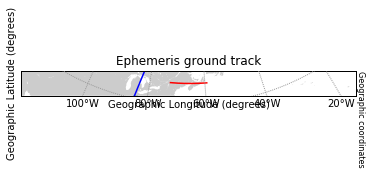

In [9]:
from davitpy.utils import plotUtils

font = {'fontname':'Computer Modern'}
m = plotUtils.mapObj(lat_0=np.mean(plats), lon_0=np.mean(plons), width=4.0*(max(plons) - min(plons))*1000*180, \
                        height=1.3*(max(plats) -  min(plats))*1000*180, coords='geo',resolution='i',datetime=time18)

x,y = m(plons,plats,coords='geo')
m.plot(x,y,'r',label='Plasma intersections')
x2,y2 = m(lons18,lats18,coords='geo')
m.plot(x2,y2,'b',label='ePOP ground track')
x3,y3 = m([lon18],[lat18],coords='geo')
m.scatter(x3,y3,s=16)
plt.xlabel('Geographic Longitude (degrees)')
plt.ylabel('Geographic Latitude (degrees)')
plt.title('Ephemeris ground track')
plt.show()